# CEE 690-02

# Environmental Spatial Data Analysis

# Lecture 25

# Logistics

* Need to determine order of presentations
* Projects do not need to be completed by the time of the presentation
* TA evaluations at the end of the class

# Project Report

* Due 12/16 via email. 
* Max 15 pages. 
* Needs to have the structure of a paper
    * Abstract
    * Introduction
    * Data and Methods
    * Results
    * Discussion
    * Conclusions
    * Acknowledgements
* Each section of the paper needs to actually say something. You can't just repeat the previous section.
* The Acknowledgements section needs to describe what each person did in the project. 
* Strong preference: Put the project's workflow in a GitHub repository and share a link to it in the report. 
    * Why? I need to be able to tell that you performed your project's using the course materials.
    * It's not necessary, but it would help...

# Outline

* Optimizing your code
* Parallelization

# Optimizing your code

# There is a reason why we are talking about this last...

“Premature optimization is the root of all evil (or at least most of it) in programming.” 

Donald Knuth

# Main approaches to speed up Python code

* Be smart in how you code (review good coding practices)
* Obtaining compiled language speed in Python
* Parallelizing your code

# Speed up code: Compiled language speed in Python

# Let's use the elevation data from Mt. Diablo

In [ ]:
%%bash 
gdalwarp -overwrite -r cubic -te -121.97 37.85 -121.88 37.92 -t_srs EPSG:4326 -tr 0.000027777 0.000027777 /data/3DEP/ned19_n38x00_w122x00_ca_contracostaco_2008.img ../Workspace/tmp.tif
gdalwarp -overwrite -dstnodata -9999 -r cubic -tr 1 1 -t_srs '+proj=aea +lat_1=37.85 +lat_2=37.92 +lat_0=37.885 +lon_0=-121.93 +x_0=0 +y_0=0 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs' ../Workspace/tmp.tif ../Workspace/dem.tif

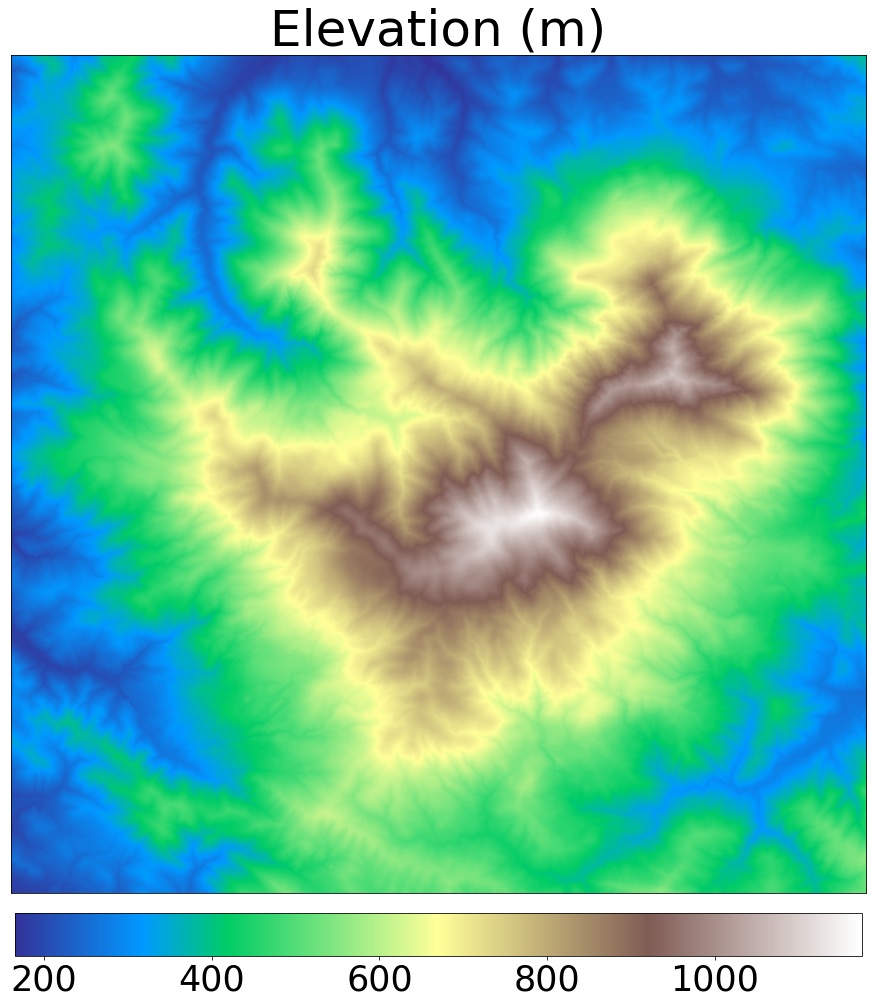

In [2]:
import rasterio
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
dem = rasterio.open('../Workspace/dem.tif').read(1)[10:-10,10:-10]
plt.figure(figsize=(15,15))
plt.imshow(dem,cmap='terrain')
plt.xticks([])
plt.yticks([])
cb = plt.colorbar(orientation='horizontal',shrink=0.8,pad=0.02)
cb.ax.tick_params(labelsize=35)
plt.title('Elevation (m)',fontsize=50)
plt.tight_layout()
plt.show()

In [26]:
print('size of array: %d' % dem.size)

size of array: 61224849


# Calculating a mean

In [27]:
def calculate_mean(data):
    val = 0
    count = 0
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            val += data[i,j]
            count += 1
    val = val/count
    return val

# Numpy vs Pure Python

In [28]:
#Pure Python
%timeit -n 1 calculate_mean(dem)

29.5 s ± 213 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
#Numpy
%timeit -n 1 np.mean(dem)

55.5 ms ± 1.77 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


2-3 orders of magnitude faster!

# But why?

In [30]:
%%HTML
<iframe width="806" height="453" src="https://www.youtube.com/embed/JNMy969SjyU" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

# Most common compiled languages used in environmental/earth sciences

* C
* C++
* Fortran

NumPy is written in C but compiled as a Python package, thus making the compiled C speed available to Python.

In [31]:
%%writefile test_library.f90
subroutine calculate_mean_fortran(data,nx,ny)
    integer,intent(in) :: nx,ny
    real,intent(in) :: data(nx,ny)
    real :: val
    integer :: count,i,j
    val = 0.0
    count = 0
    do i = 1,nx
      do j = 1,ny
        val = val + data(i,j)
        count = count + 1
      enddo
    enddo
    val = val/count
end subroutine

Overwriting test_library.f90


In [34]:
%%bash
f2py -c test_library.f90 -m test_library

running build
running config_cc
unifing config_cc, config, build_clib, build_ext, build commands --compiler options
running config_fc
unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
running build_src
build_src
building extension "test_library" sources
f2py options: []
f2py:> /tmp/tmpfqqp5tun/src.linux-x86_64-3.7/test_librarymodule.c
creating /tmp/tmpfqqp5tun/src.linux-x86_64-3.7
Reading fortran codes...
	Reading file 'test_library.f90' (format:free)
Post-processing...
	Block: test_library
			Block: calculate_mean_fortran
Post-processing (stage 2)...
Building modules...
	Building module "test_library"...
		Constructing wrapper function "calculate_mean_fortran"...
		  calculate_mean_fortran(data,[nx,ny])
	Wrote C/API module "test_library" to file "/tmp/tmpfqqp5tun/src.linux-x86_64-3.7/test_librarymodule.c"
  adding '/tmp/tmpfqqp5tun/src.linux-x86_64-3.7/fortranobject.c' to sources.
  adding '/tmp/tmpfqqp5tun/src.linux-x86_64-3.7' to include_dirs.
copy

In file included from /opt/conda/lib/python3.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1830:0,
                 from /opt/conda/lib/python3.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/lib/python3.7/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from /tmp/tmpfqqp5tun/src.linux-x86_64-3.7/fortranobject.h:13,
                 from /tmp/tmpfqqp5tun/src.linux-x86_64-3.7/fortranobject.c:2:
/opt/conda/lib/python3.7/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
 #warning "Using deprecated NumPy API, disable it with " \
  ^~~~~~~
In file included from /opt/conda/lib/python3.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1830:0,
                 from /opt/conda/lib/python3.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 fr

In [35]:
import test_library
%timeit -n 1 test_library.calculate_mean_fortran(dem,dem.shape[0],dem.shape[1])

258 ms ± 7.46 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Comparison:

* Pure Python: 29.5 s
* Numpy: 55.1 ms
* Compiled Fortran library: 258 ms

Using a compiled library (and optimized) can lead to big differences in compute time.

# Similar approaches for connecting C/C++/Fortran with Python

* Cython
* F2PY
* SWIG
* ...

# However, all of these take time to learn

Wouldn't it be nice if Python just "knew" how to optimize our Python function?

# That's Numba!

Based on the idea of "Just in Time" compiling (JIT)

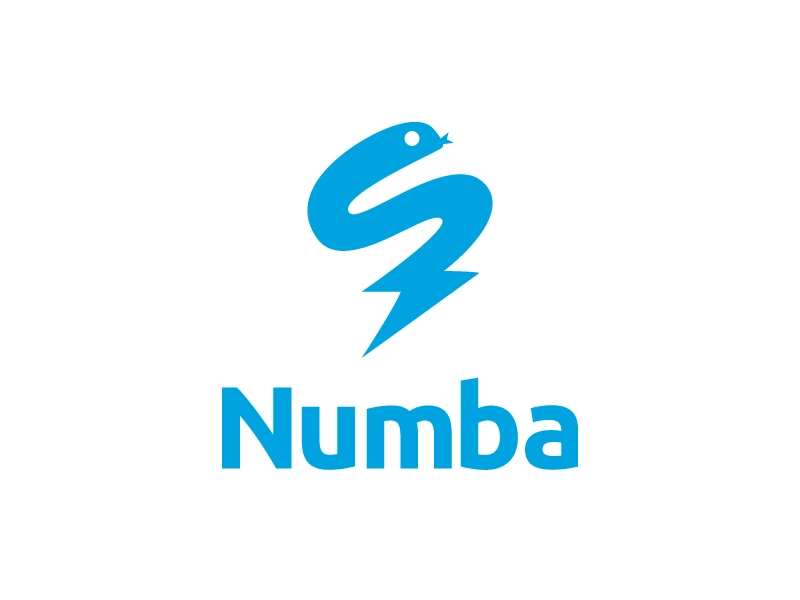

# Numba example

In [36]:
import numba
@numba.njit()
def calculate_mean_numba(data):
    val = 0
    count = 0
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            val += data[i,j]
            count += 1
    return val/count

In [37]:
#Numba implementation
%timeit -n 1 val = calculate_mean_numba(dem)

102 ms ± 41.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Comparison:

* Pure Python: 29.5 s
* Numpy: 55.1 ms
* Compiled Fortran library: 258 ms
* Numba: 102 ms

Using Numba we get *very* close to the Numpy performance. 

In other words, if there is an operation that Numpy does not have, if we write using Python code and use Numba, we can reach close to optimal performance.

# So I can use Numba to speed up all my code, right? 

Not really...

Numba will only make a large difference with for loops and array operations (which arguably is already a lot).

# Speed up code: Parallelization

Why not just distribute my tasks among many compute cores?

A common laptop now usally comes with 4-8 cores. 

They also have GPUs which we can also use for parallelization.

We could have spent the entire second half of the course on this topic... So this is not going to be comprehensive at all.

# Why parallelize? Moore's law cannot be sustained

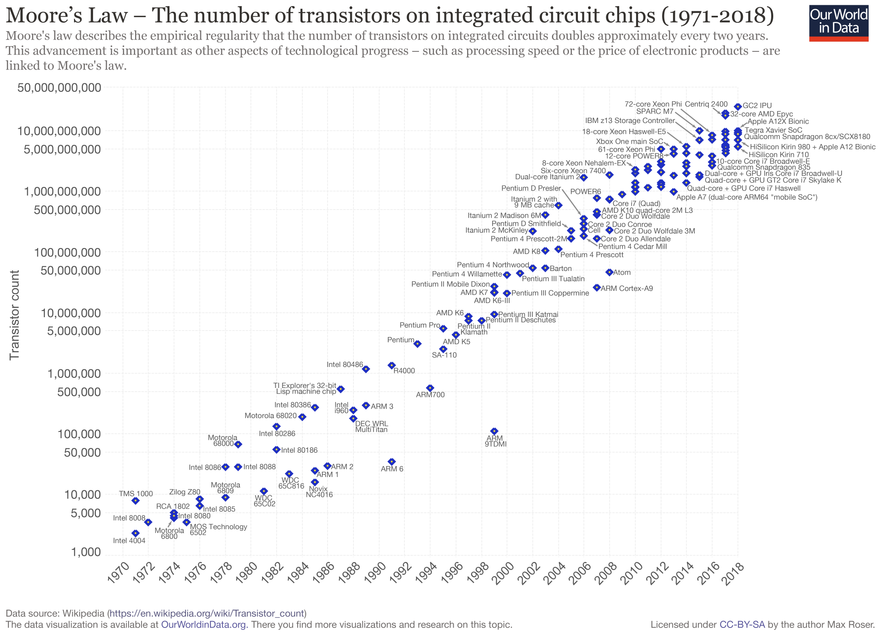

Simply using faster cores, is the easy way to speed up your code by maintining the "serial" aspect of the code while just increasing the execution speed. 

Over the next decade, our ability to continue making faster compute cores will likely start to asymptote (until quantum computing takes over...).

# Alternative? 

Instead of using only one single core replace that with multiple interconnected cores

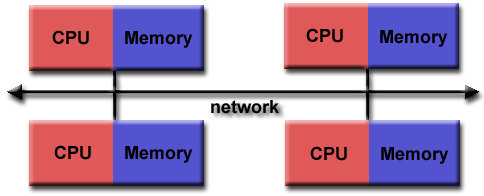

# High performance computing (HPC)

Imagine taking all your laptops and connecting them to create one "single" machine. That is the basics of High Performance Computing.

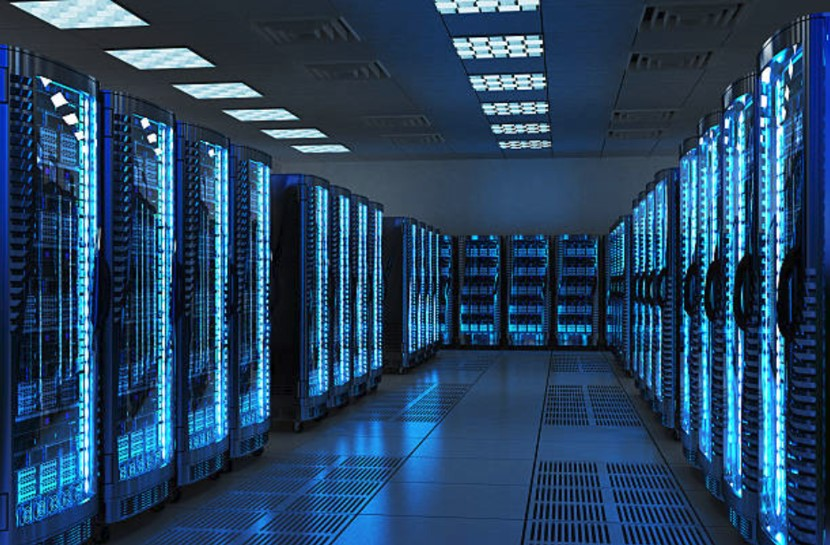

# HPC over the years

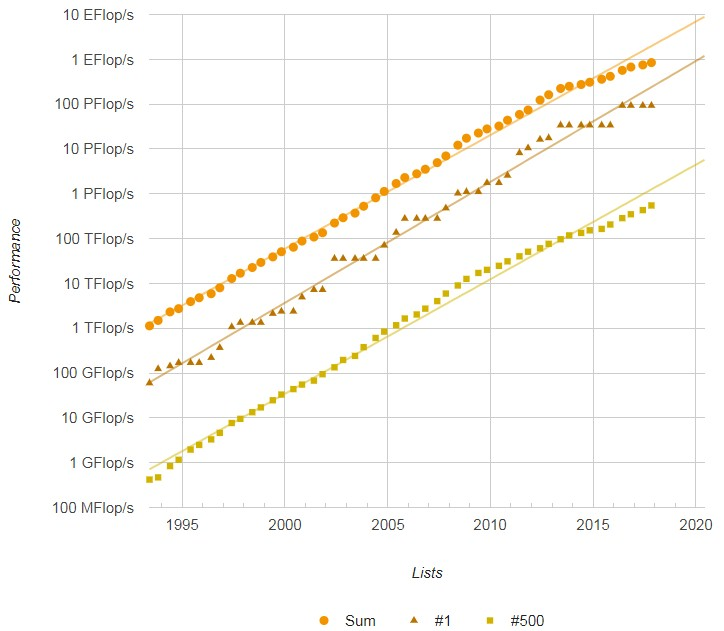

# High Performance Computing: Lots of cores...

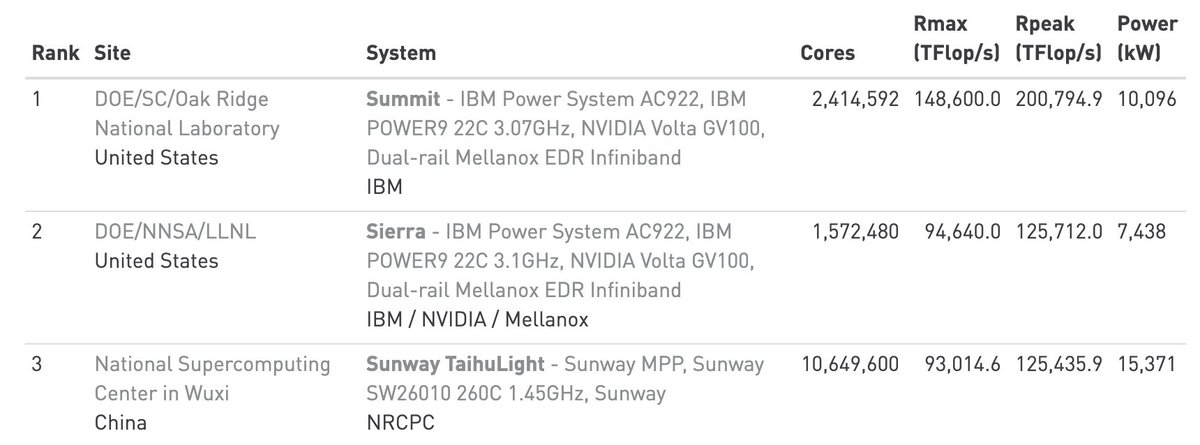

Note: Not all cores all the same

# Shared vs. Distributed memory

# Parallelization approach : Shared memory

This is the type of parallel computing that you have on your laptops/desktops.

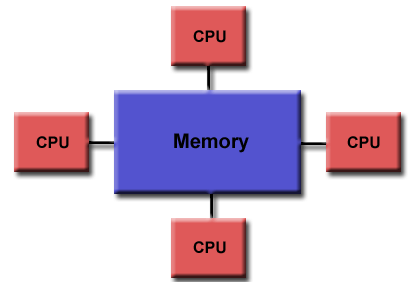

# Shared memory:  OpenMP

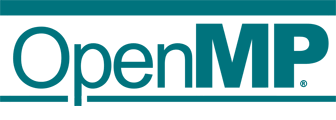

# Shared memory in Python

There are many ways. We are going to explore using Numba (which uses OpenMP under the hood).

In [38]:
print('Number of threads available: %d' % numba.config.NUMBA_NUM_THREADS)

Number of threads available: 8


In [39]:
import numba
@numba.njit(parallel=True)
def calculate_mean_numba_parallel(data):
    val = 0
    count = 0
    for i in numba.prange(data.shape[0]):
        for j in numba.prange(data.shape[1]):
            val += data[i,j]
            count += 1
    return val/count

In [42]:
%timeit -n 1 val = calculate_mean_numba_parallel(dem)

13.4 ms ± 1.88 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Comparison:

* Pure Python: 29.5 s
* Numpy: 55.1 ms
* Compiled Fortran library: 258 ms
* Numba: 102 ms
* Numba (8 threads): 13.4 ms

Using Numba + threading we can get very fast performance. 

# Parallelization approach: Distributed memory

A necessity when moving to 100s+ cores. 

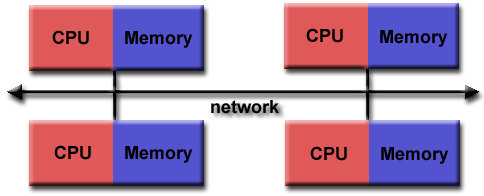

# Distributed memory: MPI

* MPI - Message Passage Interface
* Remains the standard when going to hundreds to millions of cores
* The Google/Amazon/Microsoft world is going to make it obselete in the short term (opinion). 

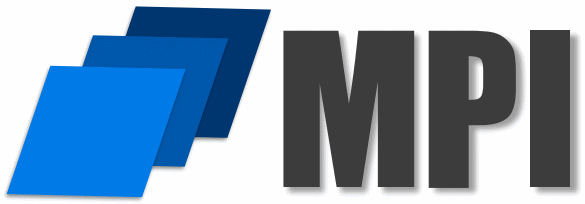

# MPI in Python: mpi4py

In [59]:
%%HTML
<iframe width="806" height="453" src="https://mpi4py.readthedocs.io/en/stable/index.html" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

# Parallelization approach: Shared + Distributed memory (Hybrid)

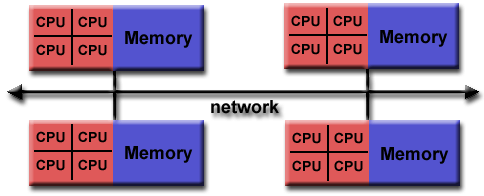

# Now we are ready for DASK

In [63]:
%%HTML
<iframe width="806" height="453" src="https://dask.org/" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

# Example using DASK

In [64]:
#Ask for resources
import dask.distributed
client = dask.distributed.Client(processes=False, threads_per_worker=8,
                n_workers=1, memory_limit='2GB')

/opt/conda/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [65]:
client

Client Scheduler: inproc://172.17.0.5/6463/19 Dashboard: http://localhost:34375/status,Cluster Workers: 1 Cores: 8 Memory: 2.00 GB


In [71]:
# Divide our array among the 8 cores into chunks
import dask.array
dem_dask = dask.array.from_array(dem,chunks=(3000,3000))

In [72]:
dem_dask

dask.array<array, shape=(7749, 7901), dtype=float32, chunksize=(3000, 3000)>

In [69]:
%timeit -n 1 dem_dask.mean().compute()

The slowest run took 10.61 times longer than the fastest. This could mean that an intermediate result is being cached.
39.7 ms ± 27.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [70]:
client.close()

# DASK makes parallelization of array operations **REALLY** easy

All these approaches that I have shown use CPUs. Most can be extended to use GPUs as well. 

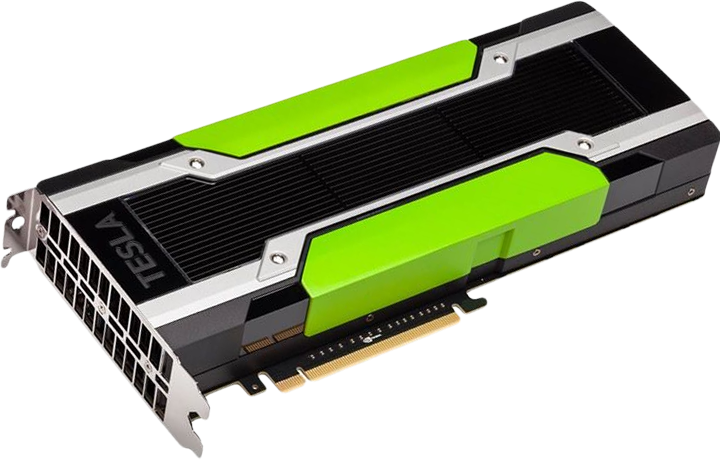

# CPU vs GPU

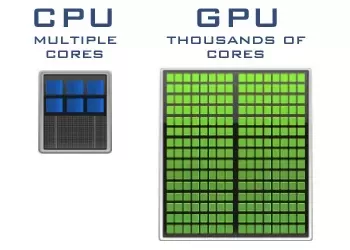

# Do GPUs make a difference?

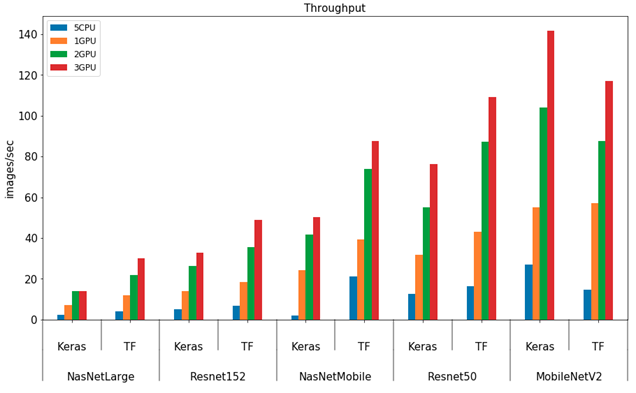

GPUs are playing an increasingly large role in Deep Learning

# Where HPC appears to be heading...

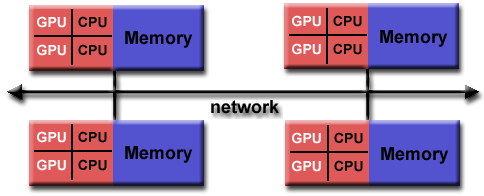

# Enough...

# We have come a long way...

* Programming in Python
* Basics of command line
* Code repositories (Git + Github)
* Data storage formats (e.g., NetCDF)
* Basic statistics and time series analysis for n-dimensional arrays
* Map projections (GDAL!)
* Cluster analysis
* Tree-based methods for classification and regression
* Vector data
* Geostatistics
* Terrain Analysis
* Code optimization

Hopefully you will use what that you learned!

# The End